In [1]:
"""Run an experiment locally from a config file.

We suggest that you use batch_runner.py for large scale experiments.
However, if you just want to play around with a smaller scale experiment then
this script can be useful.

The config file defines the selection of agents/environments/seeds that we want
to run. This script then runs through the first `N_JOBS` job_id's and then
collates the results for a simple plot.

Effectively, this script combines:
  - running `batch_runner.py` for several job_id
  - running `batch_analysis.py` to collate the data written to .csv

This is much simpler and fine for small sweeps, but is not scalable to large
parallel evaluations.

"""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import importlib
import os
import sys

from base import config_lib

import numpy as np
import pandas as pd
import plotnine as gg

# Presented here for clarity.
LIST_OF_VALID_CONFIGS = ['finite_arm.config_simple',
                         'finite_arm.config_simple_rand',
                         'finite_arm.config_simple_sanity',
                         'finite_arm.config_misspecified',
                         'finite_arm.config_drift',
                         'cascading.config_cascading',
                         'ensemble_nn.config_nn',
                         'graph.config_indep',
                         'graph.config_indep_binary',
                         'graph.config_correlated',
                         'graph.config_correlated_sanity',
                         'pricing.config_pricing']

CONFIG_PATH = 'logistic.config_logistic'
    #'finite_arm.config_simple'
N_JOBS = 3
    #100


#############################################################################
# Running from a local config file
sys.path.append(os.getcwd())

# Loading in the experiment config file
config_module = importlib.import_module(CONFIG_PATH)
config = config_module.get_config()

results = []
for job_id in range(N_JOBS):
  # Running the experiment.
  job_config = config_lib.get_job_config(config, job_id)
  experiment = job_config['experiment']
  experiment.run_experiment()
  results.append(experiment.results)


#############################################################################
# Collating data with Pandas
params_df = config_lib.get_params_df(config)
df = pd.merge(pd.concat(results), params_df, on='unique_id')
plt_df = (df.groupby(['agent', 't'])
          .agg({'instant_regret': np.mean})
          .reset_index())


#############################################################################
# Plotting and analysis (uses plotnine by default)
gg.theme_set(gg.theme_bw(base_size=16, base_family='serif'))
gg.theme_update(figure_size=(12, 8))

p = (gg.ggplot(plt_df)
     + gg.aes('t', 'instant_regret', colour='agent')
     + gg.geom_line())
print(p)





<Figure size 1200x800 with 1 Axes>

<ggplot: (8750347176757)>


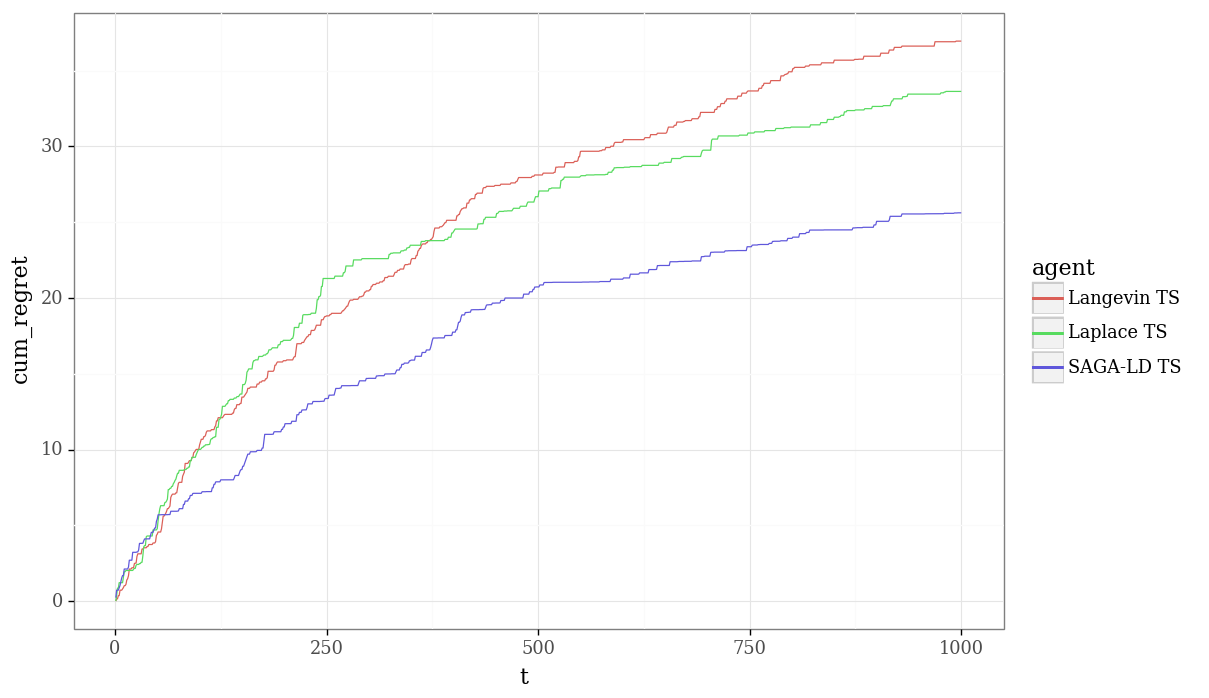

<ggplot: (8750435407445)>

In [2]:
plt_df_cum_regret = (df.groupby(['agent', 't'])
          .agg({'cum_regret': np.mean})
          .reset_index())

q = (gg.ggplot(plt_df_cum_regret)
     + gg.aes('t', 'cum_regret', colour='agent')
     + gg.geom_line())
q